<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Behavioral_Data_Analysis/blob/master/Tutorial_EntityEmbedding%EC%82%AC%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
np.random.seed(123) #ensure reproducibility
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

plt.style.use('seaborn') # matplotlib 도 종류가 다양하기 때문에 seaborn 스타일로 지정한 거임.
sns.set(font_scale=1) # (기본으로) 폰트 크기 2.5로 지정 미리 해놓는거임, 2.5면 꽤 크게 나옴

#ignore warnings
import warnings
#warnings.filterwarnings('ignore')

%matplotlib inline 


import numpy as np # linear algebra
import pandas as pd 

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model



#train = pd.read_csv('drive/My Drive/데이콘_천체유형/train.csv', index_col=0)
train = pd.read_csv('drive/My Drive/데이콘_천체유형/이상치_최대한_적게_train.csv', index_col=None)
test = pd.read_csv('drive/My Drive/데이콘_천체유형/test.csv', index_col=0)
sample_submission = pd.read_csv('drive/My Drive/데이콘_천체유형/sample_submission.csv', index_col=0)

print('csv 파일 (train, test, sample)을 불러왔습니다')
print('train shape : {0}'.format(train.shape))
print('test shape : {0}'.format(test.shape))
print('='*50)
# TRAIN 데이터의 TYPE을 SAMPLE_SUBMISSION에 대응하는 가변수 형태로 변환시킵니다.
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

#train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

notin_test = list(set(train['fiberID']) - set(test['fiberID']))## 81개
in_test = list(set ( test['fiberID']) )

#print(train.shape[0])
select_train = pd.DataFrame()
for i in range(len(in_test)):
  select_train0 = train.loc[train['fiberID']==in_test[i],:]
  select_train = pd.concat([select_train, select_train0],axis=0)
select_train = select_train.sort_index()
print( 'Test에 없는 fiberID를 Train에서도 제거한 후 Train set 갯수 : %s'  % select_train.shape[0]) ## 1769개의 트레인데이터가 빠짐

###################################### fiberID에 대해서 각각 Scaling ##################################
def scalingDF_by_fID(select_train, test, use_stc=True):
  contiunuous = list(  select_train.columns.drop(['type','fiberID','type_num']) )
  needscaling0 = select_train.loc[:,contiunuous]
  needscaling0_test = test.loc[:,contiunuous]
  fID_index = list(select_train.loc[:,'fiberID'].value_counts().index)

  #fiberIDnum = select_train.loc[:,'fiberID']
  #fiberIDnum

  scaled_train = pd.DataFrame()
  scaled_test = pd.DataFrame()

  if use_stc:

    ## Train set
    sc = StandardScaler()
    sc.fit( needscaling0 )
    stc_train = pd.DataFrame(sc.transform(needscaling0),
                          columns=needscaling0.columns,
                          index = needscaling0.index)
    scaled_train = pd.concat([stc_train,   select_train.fiberID],axis=1)

    ## Test set
    stc_test = pd.DataFrame(sc.transform(needscaling0_test),
                      columns=needscaling0_test.columns,
                      index = needscaling0_test.index)
    scaled_test = pd.concat([stc_test,test.fiberID],axis=1)



  else:                     ## Train set Robustscale
    ## Train set
    rb = RobustScaler()
    rb.fit( needscaling0 )
    rbs_train = pd.DataFrame(rb.transform(needscaling0),
                          columns=needscaling0.columns,
                          index = needscaling0.index)
    scaled_train = pd.concat([rbs_train,   select_train.fiberID],axis=1)

    ## Test set
    
    rbs_test = pd.DataFrame(rb.transform(needscaling0_test),
                      columns=needscaling0_test.columns,
                      index = needscaling0_test.index)
    scaled_test = pd.concat([rbs_test,test.fiberID],axis=1)
    
  scaled_train = scaled_train.sort_index()
  scaled_test = scaled_test.sort_index()

  return scaled_train, scaled_test



tr, tst = scalingDF_by_fID(select_train=select_train, test=test, use_stc=True)


def dummies_fID(dataframe):
  import pandas as pd
  dummy = pd.get_dummies(dataframe['fiberID'], prefix='fid')
  dataframe = pd.concat( [dataframe.drop(['fiberID'],axis=1),dummy], axis=1 )


  return dataframe

  
#tr = dummies_fID(tr)
#tst = dummies_fID(tst)


tr['type_num'] = select_train.type_num

# fiberID랑 type_num 빼고 연속형의 colname
fiber_col = tr.columns[5:10].tolist()                                      ## fiberMag
other_col = tr.columns[ list(range(0,5)) + list(range(10,20)) ].tolist()  ## psfMag, modelMag, petroMag


#np.random.seed(123) #ensure reproducibility
#random_index = list(np.random.permutation(list(tr.index)))
#tr = tr.loc[random_index,:]
#train_x = tr.drop(['type_num'], axis = 1)
#train_y = tr['type_num']

#X = tr.drop(['type_num'], axis = 1)
#Y = tr['type_num']
#train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.05, random_state=42)


col_vals_dict = {c: list(tr[c].unique()) for c in tr.columns if c == 'fiberID'}

embed_cols = []
for c in col_vals_dict:
    if len(col_vals_dict[c])>2:
        embed_cols.append(c)
        print(c + ': %d values' % len(col_vals_dict[c])) #look at value counts to know the embedding dimensions


csv 파일 (train, test, sample)을 불러왔습니다
train shape : (199899, 23)
test shape : (10009, 21)
Test에 없는 fiberID를 Train에서도 제거한 후 Train set 갯수 : 198130
fiberID: 919 values


In [0]:
!pip install keras-swa


  Created wheel for keras-swa: filename=keras_swa-0.1.4-cp36-none-any.whl size=8495 sha256=6cff2f02a383b5db4f28337089580b6ed2b509f2affa38a5fea629f0e1c219be
  Stored in directory: /root/.cache/pip/wheels/ec/99/c1/e08fe5eb0b807b44c15de29546ed0ce09f918d562e88368d2d
Successfully built keras-swa


In [0]:
import numpy as np
import pandas as pd

#random seeds for stochastic parts of neural network 
np.random.seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

from keras.models import Sequential, Model, load_model
from keras.layers import  Activation,  Lambda, Flatten, LeakyReLU, ELU, Dense
from keras.layers import Input, Concatenate, Reshape, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import Adam, SGD,RMSprop
from keras import  backend as K
from keras import metrics
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from swa.keras import SWA # swa optimizer - https://pypi.org/project/keras-swa/
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import EarlyStopping, ModelCheckpoint

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})

X_train = tr.drop(['type_num'],axis=1)
y_train = tr['type_num']
X_test = tst


def build_embedding_network():
    
    inputs = []
    embeddings = []
    

    input_fiberID = Input(shape=(1,), dtype='int32')
    embedding = Embedding(919, 50, input_length=1)(input_fiberID) ## 보통 Embedding size를 min( 50, number of categories )로 정한다고 한다.
    embedding = Dropout(0.1)(embedding)
    embedding = Reshape(target_shape=(50,))(embedding)
    inputs.append(input_fiberID)
    embeddings.append(embedding)
    
    
    input_numeric = Input(shape=(20,), dtype='float32')
    embedding_numeric = Dense(20)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)

    x = Concatenate()(embeddings)

    x = Dense(2353, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.2)(x)

    x = Dense(2343, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.2)(x)

    x = Dense(1191, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.1)(x)

    x = Dense(1181, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.1)(x)

    x = Dense(610, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.05)(x)

    x = Dense(591, activation=None)(x)
    x = BatchNormalization()(x)
#    x = ELU()(x)
    x = Activation(gelu)(x)
    x = Dropout(.05)(x)

    x = Dense(572, activation='gelu')(x)
#    x = Dropout(.05)(x)
    
    output = Dense(19, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(lr=lr,
                                 #decay = lr_d
                                 ),
                  metrics=['accuracy'])
    
    return model



#converting data to list format to match the network structure
def preproc(X_train, #X_val,
            X_test):

    input_list_train = []
    #input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # of values)
    for c in embed_cols:
        raw_vals = np.unique(tr[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        #input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    #input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train,  input_list_test   #input_list_val,
      


########### CosineAnnealingScheduler

import math
from keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        #if self.verbose &gt; 0:
        if self.verbose != 0:
        
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [0]:
csv_folder = '0216_Entity_Embedding_스케쥴러'

import os
SAVEMODEL_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder
if not os.path.exists(SAVEMODEL_NEWFOLDER):
  os.mkdir(SAVEMODEL_NEWFOLDER)
SUBMISSION_NEWFOLDER = 'drive/My Drive/데이콘_천체유형/파일제출/' + csv_folder
if not os.path.exists(SUBMISSION_NEWFOLDER):
  os.mkdir(SUBMISSION_NEWFOLDER)


check_path = SAVEMODEL_NEWFOLDER + '{epoch:02d}-{val_loss:.4f}.hdf5'
json_path = SAVEMODEL_NEWFOLDER + "model1.json"
weight_path = SAVEMODEL_NEWFOLDER +"model1.h5"



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 182279 samples, validate on 15851 samples





Model uses batch normalization. SWA will require last epoch to be a forward pass and will run with no learning rate
Epoch 1/100
182279/182279 [==============================] - 15s 80us/step - loss: 0.5602 - acc: 0.8156 - val_loss: 0.6083 - val_acc: 0.7967
Epoch 2/100
182279/182279 [==============================] - 12s 64us/step - loss: 0.4673 - acc: 0.8406 - val_loss: 1.4252 - val_acc: 0.6728
Epoch 3/100
182279/182279 [==============================] - 12s 63us/step - loss: 0.4644 - acc: 0.8432 - val_loss: 0.6262 - val_acc: 0.7939
Epoch 4/100
182279/182279 [==============================] - 12s 64us/step - loss: 0.4467 - acc: 0.8473 - val_loss: 0.4413 - val_acc: 0.8527
Epoch 5/100
182279/182279 [==============================] - 12s 64us/step - loss: 0.4277 - acc: 0.8540 - val_loss: 0.5002 - val_acc: 0.8269
Epoch 6/100
182279/182279 

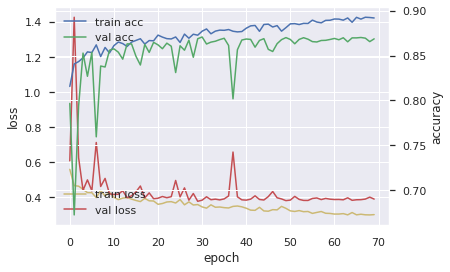

In [0]:
lr = 3e-4
n_epochs = 100
pat =  40
batchsize = 256*4
lr_d = 0.0
epoch =  500
start_epoch = 10

X_train_f = tr.drop(['type_num'], axis = 1)
y_train_f = tr['type_num']

# Shuffle data
idx = np.arange(len(X_train_f))
np.random.shuffle(idx)
X_train_f = X_train_f.iloc[idx]
y_train_f = y_train_f.iloc[idx]
X_test_f = tst.copy()
# Converting data to list for Enitity Embedding
proc_X_train_f, proc_X_test_f = preproc(X_train_f, X_test_f)

nn_model = build_embedding_network()

### model early stopping
es = EarlyStopping(monitor= 'val_loss', patience = pat, verbose = 1, mode='auto') # 더이상 성능 개선이 되지 않으면 멈춤

### model check point
mc = ModelCheckpoint(filepath=check_path, monitor='val_loss', mode='auto', save_best_only=True)

### 코사인 스케쥴러
cosine_scheduler = CosineAnnealingScheduler(T_max=n_epochs, eta_max=6e-4, eta_min=3e-5)

### Stochastic warm restarts
swa = SWA(start_epoch=start_epoch, lr_schedule='manual', swa_lr=3e-4, swa_freq=5, verbose=1,batch_size=batchsize)

import keras
optimizer = keras.optimizers.Adam(
    lr=lr,
)

## compile model
nn_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])








import os
MODEL_SAVE_FOLDER_PATH = 'drive/My Drive/데이콘_천체유형/ModelCheck/' + csv_folder +  '/rate=%s/' % lr
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)
check_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
json_path = MODEL_SAVE_FOLDER_PATH + "model1.json"
weight_path = MODEL_SAVE_FOLDER_PATH +"model1.h5"


## fitting model
hist = nn_model.fit(proc_X_train_f,
          y_train_f,
          batch_size=batchsize,
          validation_split=0.08,
          epochs=n_epochs,
          callbacks = [es ,mc,cosine_scheduler,swa
                       ])

## save model
model_json = nn_model.to_json()
with open(json_path, "w") as json_file : 
    json_file.write(model_json)
## model weight save
#nn_model.save_weights(weight_path)
print("모델저장완료")
print("="*50)

print("Loss와 ACC에 대한 Plot을 그립니다")


fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [0]:
savingpath_csv = SUBMISSION_NEWFOLDER + '/EntityEmbedding_GELU_rate_%s.csv' % lr
y_pred = nn_model.predict(proc_X_test_f)
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv(savingpath_csv, index=True)